In [ ]:

!pip install datasets transformers torch accelerate

In [1]:
from datasets import load_dataset
dataset_train = load_dataset("keremberke/shoe-classification",'full', split='train')

In [2]:
#사전학습 Vision 트랜스포머 불러오기
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.neighbors import NearestNeighbors
import torch

# import model - https://huggingface.co/google/vit-base-patch16-224-in21k
model_id = 'google/vit-base-patch16-224-in21k'

In [3]:
%%time
model_vanilla = ViTForImageClassification.from_pretrained(model_id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 553 ms, sys: 384 ms, total: 937 ms
Wall time: 596 ms


In [4]:
%%time
feature_extractor_vanilla = ViTFeatureExtractor.from_pretrained(model_id)

CPU times: user 18.6 ms, sys: 9.25 ms, total: 27.8 ms
Wall time: 190 ms


/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
model_vanilla

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [6]:
feature_extractor_vanilla

ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
model_vanilla.classifier = torch.nn.Identity()

In [8]:

def extract_embeddings(dataset, model, feature_extractor):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for item in dataset:
            inputs = feature_extractor(images=item['image'], return_tensors="pt")
            outputs = model(**inputs)
            embeddings.append(outputs.logits.squeeze().numpy())
    return embeddings

In [9]:

def retrieve_images(index, nn_model, dataset, embeddings):
    index = int(index)
    distances, indices = nn_model.kneighbors([embeddings[index]])

    indexed_distances = [(int(i), dist) for i, dist in zip(indices[0], distances[0]) if i != index]

    indexed_distances.sort(key=lambda x: x[1])

    retrieved_images = [dataset[idx]["image"] for idx, _ in indexed_distances]
    return retrieved_images

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = dataset["train"][i]["image"]
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

In [10]:
# 33초 예상
embeddings_vanilla = extract_embeddings(dataset_train, model_vanilla, feature_extractor_vanilla)
nn_model_vanilla = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
nn_model_vanilla.fit(embeddings_vanilla)

KeyboardInterrupt: 

In [ ]:
len(embeddings_vanilla)

In [12]:
embeddings_vanilla[0].shape

(768,)

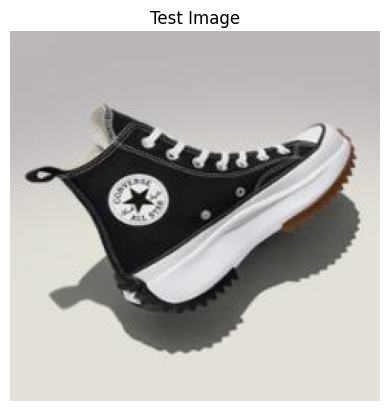

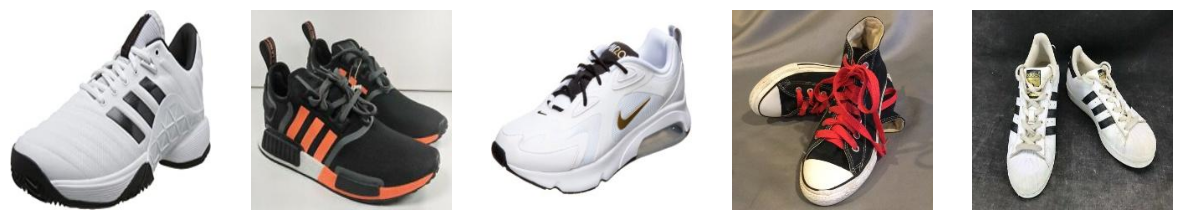

In [13]:

import matplotlib.pyplot as plt
test_index =358
retrieved_images = retrieve_images(test_index, nn_model_vanilla, dataset_train, embeddings_vanilla)

plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

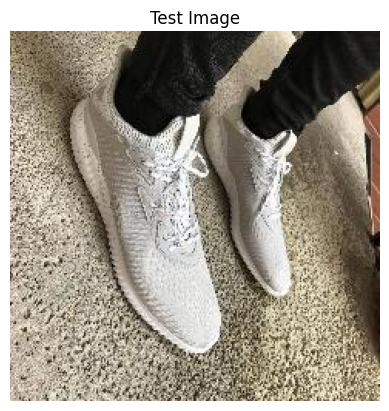

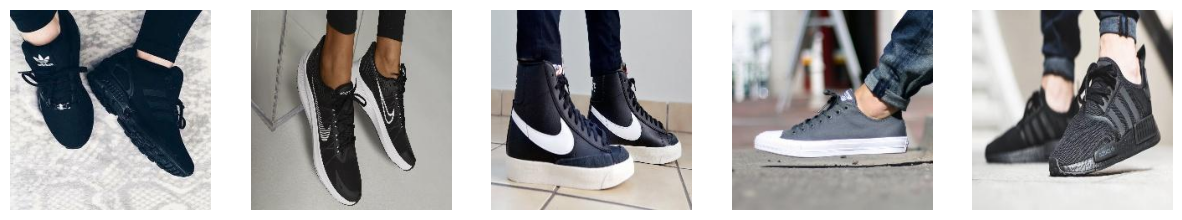

In [14]:

test_index = 65
retrieved_images = retrieve_images(test_index, nn_model_vanilla, dataset_train, embeddings_vanilla)

plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

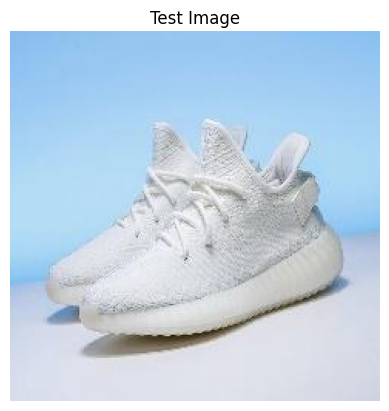

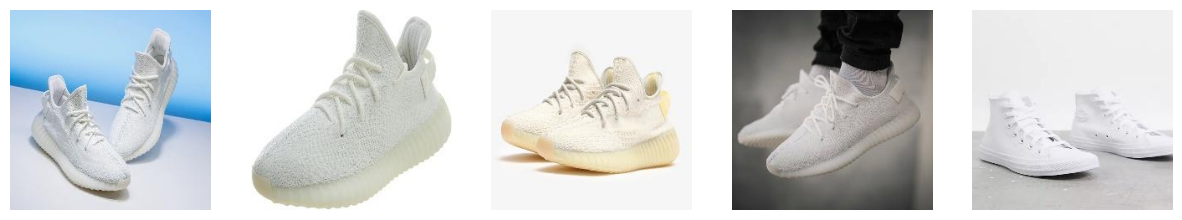

In [15]:

test_index = 94
retrieved_images = retrieve_images(test_index, nn_model_vanilla, dataset_train, embeddings_vanilla)

plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

In [11]:
%%time
#Fine-Tuning
dataset_test = load_dataset("keremberke/shoe-classification",'full', split='validation')

CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 1.71 s


In [12]:

def preprocess(batch):
    inputs = feature_extractor_vanilla(
        batch['image'],
        return_tensors='pt'
    )
    inputs['labels'] = batch['labels']
    return inputs

In [13]:
%%time
train_prepared = dataset_train.with_transform(preprocess)
test_prepared = dataset_test.with_transform(preprocess)

CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 1.48 ms


In [14]:
train_prepared

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 576
})

In [15]:
test_prepared

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 166
})

In [16]:
# 배치 텐서별 텐서와 레이블을 올바르게 정렬
def collate_batch(batch):
    pixel_vals = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    return {'pixel_values': torch.stack(pixel_vals), 'labels': torch.tensor(labels)}

In [17]:
import numpy as np
from datasets import load_metric

accuracy_metric = load_metric("accuracy")

def evaluate_model_performance(outputs):
    predicted_labels = np.argmax(outputs.predictions, axis=1)
    true_labels = outputs.label_ids
    return accuracy_metric.compute(predictions=predicted_labels, references=true_labels)

/tmp/ipykernel_110298/831075240.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [18]:

num_labels_in_dataset = len(set(dataset_train['labels']))
label_names = dataset_train.features['labels'].names

num_labels_in_dataset, label_names

(3, ['converse', 'adidas', 'nike'])

In [19]:
# ViTForImageClassification 바닐라 모델은 출력 레이블 2개 였지만, 
# 새롭게 파인튜닝 시킬 레이블 갯수는 3개
model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=num_labels_in_dataset
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [21]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:

import transformers
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./shoe",
  per_device_train_batch_size=128,
  evaluation_strategy="steps",
  num_train_epochs=8,
  save_steps=20,
  eval_steps=20,
  logging_steps=20,
  learning_rate=0.0002,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  #load_best_model_at_end=True,
)

/home/cslee/anaconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [24]:

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_batch,
    compute_metrics=evaluate_model_performance,
    train_dataset=train_prepared,
    eval_dataset=test_prepared,
    tokenizer=feature_extractor_vanilla,
)

In [ ]:
%%time
training_outcome = trainer.train()
trainer.save_model()

training_metrics = training_outcome.metrics
trainer.log_metrics("training", training_metrics)
trainer.save_metrics("training", training_metrics)

trainer.save_state()

In [ ]:

evaluation_metrics = trainer.evaluate(test_prepared)

trainer.log_metrics("evaluation", evaluation_metrics)
trainer.save_metrics("evaluation", evaluation_metrics)

In [ ]:

fine_tuned_path = './shoe'
model_finetuned = ViTForImageClassification.from_pretrained(fine_tuned_path)
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(fine_tuned_path)
model_finetuned.classifier = torch.nn.Identity()

embeddings_ft = extract_embeddings(dataset_train, model_finetuned, feature_extractor_finetuned)

nn_model_ft = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
nn_model_ft.fit(embeddings_ft)

In [ ]:
import matplotlib.pyplot as plt
test_index = 94
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

In [ ]:
test_index = 358
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

In [ ]:
test_index = 174
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

In [ ]:
test_index =383
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

In [ ]:
test_index = 65
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})